# fig2A

/home/fengyu/miniconda3/envs/st/lib/python3.8/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm



【STEP 1 | Creating output directory】

Output directory ready: /data1/fengyu/methods/zy/Review/for_github/fig2--ok/zhengli

【STEP 2 | Reading AnnData object】

AnnData loaded and cellID processed.

【STEP 3 | Extracting cell border data & building DataFrame】

Cell border data processed.

【STEP 4 | Extracting target clone family data】

- Number of clone family members: 155
- Family cell border sampling done, 155 cells
- Clone family members: 155
- Family cell border sampling done, 155 cells

【STEP 5 | Extracting tissue outline data】

Tissue outline data extracted.

【Pipeline start】


【STEP 6 | Plotting global scatter plot】



/tmp/ipykernel_90359/1961651351.py:58: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_cellborder['cellID'] = df_cellborder['cellID'].astype(int)


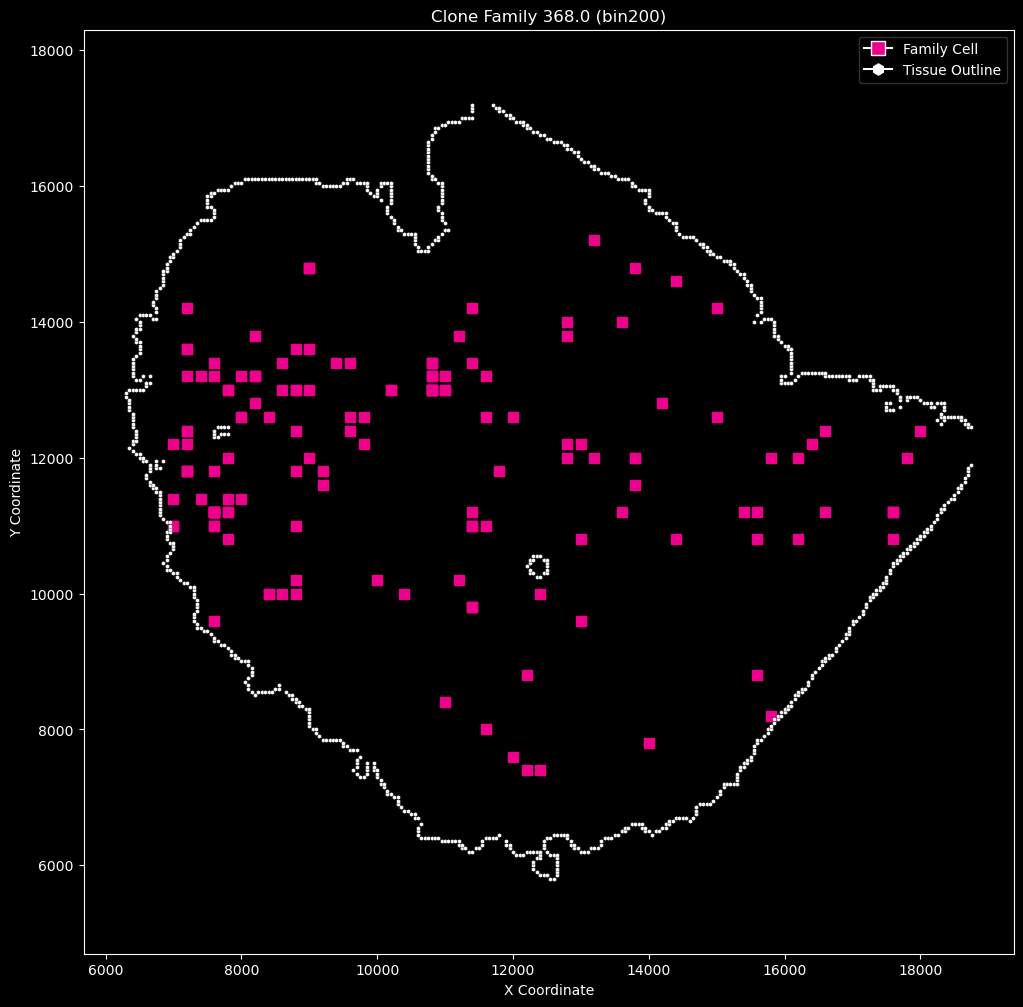

✔️ Global scatter plot saved: /data1/fengyu/methods/zy/Review/for_github/fig2--ok/zhengli/fig2A_bin200_scatterplot.png

【STEP 7 | Plotting zoomed cell border plot】



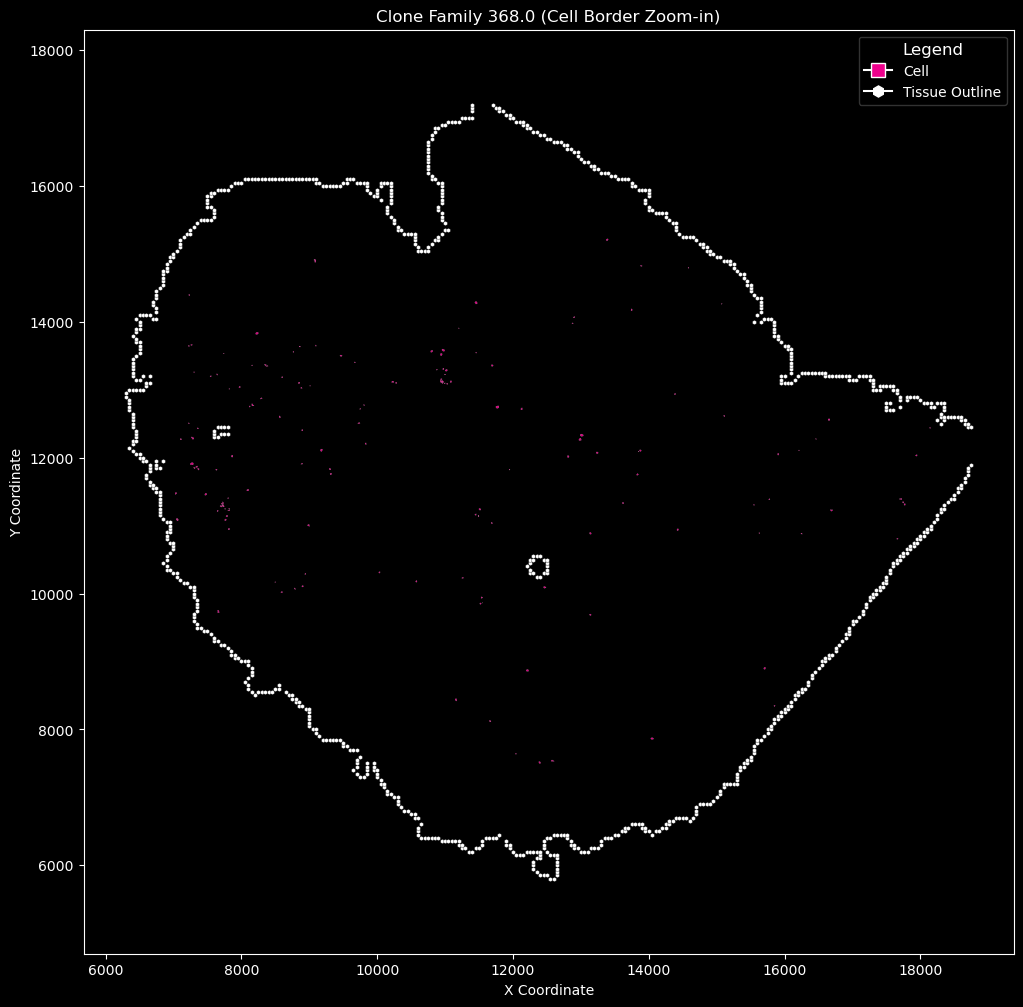

✔️ Zoomed cell border plot saved: /data1/fengyu/methods/zy/Review/for_github/fig2--ok/zhengli/fig2A-cellbin-zoomin.png

【Pipeline finished】

All figures saved to directory: /data1/fengyu/methods/zy/Review/for_github/fig2--ok/zhengli
Total run time: 34.10 seconds


In [1]:
import scanpy as sc
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from matplotlib.path import Path
from matplotlib.patches import PathPatch
from matplotlib.collections import PatchCollection
from matplotlib.lines import Line2D
from scipy.interpolate import splprep, splev
import os
import time

def print_section(title):
    print("\n" + "=" * 60)
    print(f"【{title}】")
    print("=" * 60 + "\n")

# ==== Path parameters ====
print_section("STEP 1 | Creating output directory")
DATA_PATH = '/data3/zhangyang/Method_Final_analysis/D06053D2/test_analysis_celltype/04.D06050D2_after_preprocess_Final.h5ad'
OUTDIR = '/data1/fengyu/methods/zy/Review/for_github/fig2--ok/zhengli'
os.makedirs(OUTDIR, exist_ok=True)
print(f"Output directory ready: {OUTDIR}")

# ==== 1. Data reading and preprocessing ====
print_section("STEP 2 | Reading AnnData object")
adata = sc.read_h5ad(DATA_PATH)
adata.obs['cellID'] = adata.obs['cellID'].astype(int)
print("AnnData loaded and cellID processed.")

# ==== 2. Extract cell border data ====
print_section("STEP 3 | Extracting cell border data & building DataFrame")
cell_border = adata.obsm['cell_border']
array_2d = cell_border.reshape(-1, cell_border.shape[-1])
df = pd.DataFrame(array_2d)
df['cellID'] = df.index // 32
df['cellID'] = df['cellID'].astype(int)
df.rename(columns={0: 'x', 1: 'y'}, inplace=True)
df_filtered = df[(df['x'] != 32767) & (df['y'] != 32767)].copy()
df_filtered['cellID'] = df_filtered['cellID'].astype(int)
df_filtered = pd.merge(df_filtered, adata.obs[['x', 'y', 'cellID']], on='cellID', how='left')
df_filtered['x'] = df_filtered['x_x'] + df_filtered['x_y']
df_filtered['y'] = df_filtered['y_x'] + df_filtered['y_y']
df_cellborder = df_filtered[['cellID', 'x', 'y']]
print("Cell border data processed.")

# ==== 3. Extract clone family clustering data ====
print_section("STEP 4 | Extracting target clone family data")
FAMILY_ID = 368.0
clone_expansion_color = '#ed008c'
EDGE_COLOR = 'white'

family = adata.obs[adata.obs['clone_family_id'] == FAMILY_ID].copy()
family['bin200_x'] = family['x'] // 200 * 200
family['bin200_y'] = family['y'] // 200 * 200
family['cellID'] = family['cellID'].astype(int)
df_cellborder['cellID'] = df_cellborder['cellID'].astype(int)
family_cellborder = df_cellborder[df_cellborder['cellID'].isin(family['cellID'])].copy()
family_cellborder_list = (
    family_cellborder.groupby('cellID').apply(lambda group: [[x, y] for x, y in zip(group['x'], group['y'])]).tolist()
)
family_cellborder_list = [np.array(cell) for cell in family_cellborder_list]
print(f"- Number of clone family members: {family.shape[0]}")
print(f"- Family cell border sampling done, {len(family_cellborder_list)} cells")
print(f"- Clone family members: {family.shape[0]}")
print(f"- Family cell border sampling done, {len(family_cellborder_list)} cells")

# ==== 4. Tissue outline data ====
print_section("STEP 5 | Extracting tissue outline data")
tissue_outline = pd.DataFrame(adata.uns['tissue_outline'], columns=['x', 'y'])
print("Tissue outline data extracted.")

# ==== 5. Boundary smoothing function ====
def smooth_boundary(boundary, smoothness=0.5):
    """
    Smooth boundary using B-spline
    :param boundary: np.array with shape (n_points, 2)
    :param smoothness: scalar, smoothing strength
    :return: np.array of smoothed boundary points
    """
    x = boundary[:, 0]
    y = boundary[:, 1]
    x = np.append(x, x[0])
    y = np.append(y, y[0])
    if len(x) < 4:
        return boundary
    tck, u = splprep([x, y], s=smoothness * len(x), per=True)
    u_new = np.linspace(u.min(), u.max(), 100)
    x_new, y_new = splev(u_new, tck, der=0)
    return np.column_stack((x_new, y_new))

def plot_global_bin200(family, tissue_outline, color=clone_expansion_color, outdir=OUTDIR):
    print_section("STEP 6 | Plotting global scatter plot")
    plt.style.use('dark_background')
    fig, ax = plt.subplots(figsize=(12, 12))
    fig.patch.set_facecolor('black')
    ax.set_facecolor('black')
    ax.scatter(
        family['bin200_x'], family['bin200_y'],
        color=color, s=50, marker='s', label='Clone Family'
    )
    sns.scatterplot(
        x='x', y='y', data=tissue_outline,
        color=EDGE_COLOR, marker='h', s=10,
        edgecolor='black', linewidth=0.2, ax=ax
    )
    ax.set_xlim(0, 32768)
    ax.set_ylim(0, 32768)
    ax.axis('equal')
    ax.set_xlabel("X Coordinate", color='white')
    ax.set_ylabel("Y Coordinate", color='white')
    ax.set_title(f'Clone Family {FAMILY_ID} (bin200)')
    legend_elements = [
        Line2D([0], [0], marker='s', color='w', label='Family Cell', markerfacecolor=color, markersize=10),
        Line2D([0], [0], marker='h', color='w', label='Tissue Outline', markerfacecolor=EDGE_COLOR, markersize=8)
    ]
    legend = ax.legend(handles=legend_elements, loc='upper right', frameon=True, framealpha=0.2,
                       facecolor='black', edgecolor='white', fontsize=10)
    plt.setp(legend.get_texts(), color='white')
    plt.grid(False)
    savepath = os.path.join(outdir, 'fig2A_bin200_scatterplot.png')
    plt.savefig(savepath, dpi=600, bbox_inches='tight', facecolor='black')
    plt.axis('equal')
    plt.show()
    print(f"✔️ Global scatter plot saved: {savepath}")

def plot_zoomed_cellborder(family_cellborder_list, tissue_outline, color=clone_expansion_color, outdir=OUTDIR):
    print_section("STEP 7 | Plotting zoomed cell border plot")
    plt.style.use('dark_background')
    fig, ax = plt.subplots(figsize=(12, 12))
    fig.patch.set_facecolor('black')
    ax.set_facecolor('black')
    patches = []
    for cell_boundary in family_cellborder_list:
        if len(cell_boundary) < 3:
            continue
        smoothed_boundary = smooth_boundary(cell_boundary, smoothness=0.5)
        vertices = smoothed_boundary
        codes = [Path.LINETO] * len(vertices)
        codes[0] = Path.MOVETO
        codes[-1] = Path.CLOSEPOLY
        path = Path(vertices, codes)
        patch = PathPatch(
            path, edgecolor=EDGE_COLOR, facecolor=color,
            linewidth=0.1, antialiased=True, alpha=0.9
        )
        patches.append(patch)
    if patches:
        ax.add_collection(PatchCollection(patches, match_original=True))
    sns.scatterplot(
        x='x', y='y', data=tissue_outline,
        color=EDGE_COLOR, marker='h', s=10,
        edgecolor='black', linewidth=0.2, ax=ax
    )
    ax.set_xlim(5000, 20000)
    ax.set_ylim(5000, 20000)
    ax.axis('equal')
    ax.set_xlabel("X Coordinate", color='white')
    ax.set_ylabel("Y Coordinate", color='white')
    ax.set_title(f'Clone Family {FAMILY_ID} (Cell Border Zoom-in)', color='white')
    legend_elements = [
        Line2D([0], [0], marker='s', color='w', label='Cell', markerfacecolor=color, markersize=10),
        Line2D([0], [0], marker='h', color='w', label='Tissue Outline', markerfacecolor=EDGE_COLOR, markersize=8)
    ]
    legend = ax.legend(
        handles=legend_elements, loc='upper right', frameon=True,
        framealpha=0.2, facecolor='black', edgecolor='white', fontsize=10,
        title='Legend', title_fontsize=12
    )
    plt.setp(legend.get_texts(), color='white')
    plt.grid(False)
    savepath = os.path.join(outdir, 'fig2A-cellbin-zoomin.png')
    plt.savefig(savepath, dpi=2500, bbox_inches='tight', facecolor='black')
    plt.axis('equal')
    plt.show()
    print(f"✔️ Zoomed cell border plot saved: {savepath}")

# ==== Main pipeline entry ====
if __name__ == "__main__":
    print_section("Pipeline start")
    start_time = time.time()  # Start timing

    plot_global_bin200(family, tissue_outline, color=clone_expansion_color, outdir=OUTDIR)
    plot_zoomed_cellborder(family_cellborder_list, tissue_outline, color=clone_expansion_color, outdir=OUTDIR)

    print_section("Pipeline finished")
    print(f'All figures saved to directory: {OUTDIR}')

    end_time = time.time()  # End timing

    print(f'Total run time: {end_time - start_time:.2f} seconds')

# fig2B


【STEP 1 | Reading AnnData】

AnnData loaded.

【STEP 2 | Bin grid counting & grouping】

Grid coordinates computed.
Number of TRB+ cells: 1175, IGH+ cells: 10785
Bin counting and merging done.

【STEP 3 | Drawing violin + box plot】



/tmp/ipykernel_90359/889240911.py:53: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.violinplot(
/tmp/ipykernel_90359/889240911.py:53: FutureWarning: 

The `scale` parameter has been renamed and will be removed in v0.15.0. Pass `density_norm='area'` for the same effect.
  sns.violinplot(
/tmp/ipykernel_90359/889240911.py:61: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(


✔️ Figure saved to: /data1/fengyu/methods/zy/Review/for_github/fig2--ok/zhengli/fig2B_distribution_of_isotype1_violin.pdf


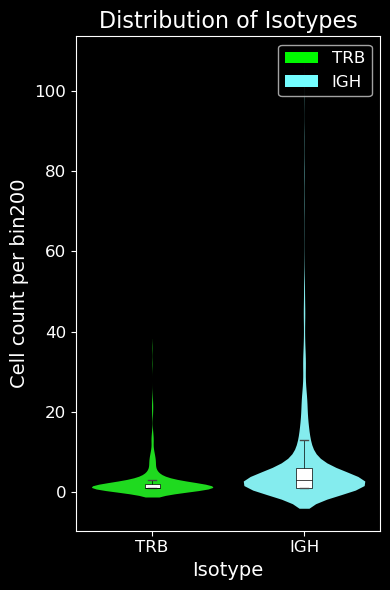


【Pipeline finished】

Total run time: 9.40 seconds


In [8]:
import scanpy as sc
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from matplotlib.patches import Patch
import os
import time

def print_section(title):
    print("\n" + "="*60)
    print(f"【{title}】")
    print("="*60 + "\n")

DATA_PATH = '/data3/zhangyang/Method_Final_analysis/D06053D2/test_analysis_celltype/04.D06050D2_after_preprocess_Final.h5ad'
OUTPATH = '/data1/fengyu/methods/zy/Review/for_github/fig2--ok/zhengli/fig2B_distribution_of_isotype1_violin.pdf'
os.makedirs(os.path.dirname(OUTPATH), exist_ok=True)

if __name__ == "__main__":
    start_time = time.time()
    print_section("STEP 1 | Reading AnnData")
    adata = sc.read_h5ad(DATA_PATH)
    print("AnnData loaded.")

    # ==============================
    print_section("STEP 2 | Bin grid counting & grouping")
    bs = 200
    adata.obs['bin200_x'] = adata.obs['x'] // bs * bs
    adata.obs['bin200_y'] = adata.obs['y'] // bs * bs
    adata.obs['bin200_location_id'] = (
        'DNB_' + adata.obs['bin200_x'].astype(str) + '_' + adata.obs['bin200_y'].astype(str)
    )
    print("Grid coordinates computed.")

    TRB = adata.obs[adata.obs['TRBcdr3aa'].notna()]
    IGH = adata.obs[adata.obs['IGHcdr3aa'].notna()]
    print(f"Number of TRB+ cells: {TRB.shape[0]}, IGH+ cells: {IGH.shape[0]}")

    TRB_counts = TRB['bin200_location_id'].value_counts().rename('y')
    IGH_counts = IGH['bin200_location_id'].value_counts().rename('y')
    TRB_1 = TRB_counts.reset_index().rename(columns={'index': 'bin200_location_id'})
    TRB_1['category'] = 'TRB'
    IGH_1 = IGH_counts.reset_index().rename(columns={'index': 'bin200_location_id'})
    IGH_1['category'] = 'IGH'
    df_all = pd.concat([TRB_1[['y', 'category']], IGH_1[['y', 'category']]], ignore_index=True)
    print("Bin counting and merging done.")

    # ==============================
    print_section("STEP 3 | Drawing violin + box plot")
    plt.figure(figsize=(4, 6))
    colors = {'TRB': '#00F900', 'IGH': '#73FDFF'}
    palette = [colors[c] for c in df_all['category'].unique()]
    sns.violinplot(
        x='category', y='y', data=df_all,
        palette=palette,
        scale='area',
        inner=None,
        linewidth=0,
        cut=2
    )
    sns.boxplot(
        x='category', y='y', data=df_all,
        width=0.1,
        boxprops=dict(facecolor='white', edgecolor='black', alpha=1, linewidth=0.5),
        medianprops=dict(color='black', linewidth=0.5),
        whiskerprops=dict(color='black', linewidth=0.5),
        showfliers=False,
        palette=palette
    )
    plt.grid(False)
    plt.title('Distribution of Isotypes', fontsize=16)
    plt.ylabel('Cell count per bin200', fontsize=14)
    plt.xlabel('Isotype', fontsize=14)
    plt.xticks(fontsize=12)
    plt.yticks(fontsize=12)

    legend_elements = [
        Patch(facecolor=colors['TRB'], label='TRB'),
        Patch(facecolor=colors['IGH'], label='IGH')
    ]
    plt.legend(handles=legend_elements, fontsize=12)
    plt.tight_layout()
    plt.savefig(OUTPATH, dpi=600, format='pdf', bbox_inches='tight')
    print(f"✔️ Figure saved to: {OUTPATH}")

    plt.show()
    end_time = time.time()
    print_section("Pipeline finished")
    print(f'Total run time: {end_time - start_time:.2f} seconds')

# fig2F


【STEP 1 | Load AnnData】

AnnData loaded.

【STEP 2 | Count clone sizes】

Statistics:
- clone size >= 10: 71
- 10 > clone size > 2: 210
- clone size = 1: 178

【STEP 3 | Plot and save pie chart】



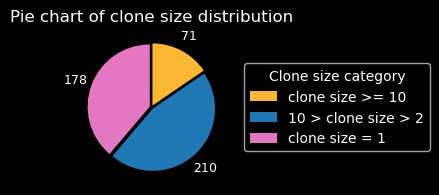

✔️ Pie chart saved: /data1/fengyu/methods/zy/Review/for_github/fig2--ok/zhengli/fig2F_clone_size_piechart.pdf

【Pipeline finished】

Total run time: 7.86 seconds


In [7]:
import scanpy as sc
import matplotlib.pyplot as plt
import numpy as np
import os
import time

def print_section(title):
    print("\n" + "="*50)
    print(f"【{title}】")
    print("="*50 + "\n")

DATA_PATH = '/data3/zhangyang/Method_Final_analysis/D06053D2/test_analysis_celltype/04.D06050D2_after_preprocess_Final.h5ad'
OUTPATH = '/data1/fengyu/methods/zy/Review/for_github/fig2--ok/zhengli/fig2F_clone_size_piechart.pdf'
os.makedirs(os.path.dirname(OUTPATH), exist_ok=True)

if __name__ == "__main__":
    start_time = time.time()
    print_section("STEP 1 | Load AnnData")
    adata11 = sc.read_h5ad(DATA_PATH)
    print("AnnData loaded.")

    print_section("STEP 2 | Count clone sizes")
    igh_count = adata11.obs['IGHcdr3aa'].value_counts()
    sizes = [
        (igh_count >= 10).sum(),
        ((igh_count >= 2) & (igh_count < 10)).sum(),
        (igh_count == 1).sum()
    ]
    colors = ["#FCB735","#1F77B4",'#E377C2']
    labels = [
        "clone size >= 10",
        "10 > clone size > 2",
        "clone size = 1"
    ]
    print("Statistics:")
    for l,s in zip(labels, sizes):
        print(f"- {l}: {s}")

    print_section("STEP 3 | Plot and save pie chart")
    plt.style.use('dark_background')
    fig, ax = plt.subplots(figsize=(4, 4))

    explode = [0.03] * len(sizes)  # The distance that each wedge is exploded outwards
    wedges, texts = ax.pie(
        sizes,
        explode=explode,
        colors=colors,
        startangle=90,
        counterclock=False,
        wedgeprops=dict()
    )

    # Mark the corresponding number outside each sector
    for i, (w, s) in enumerate(zip(wedges, sizes)):
        ang = (w.theta1 + w.theta2) / 2
        x = np.cos(np.deg2rad(ang))
        y = np.sin(np.deg2rad(ang))
        ax.text(x * 1.30, y * 1.30, str(s),
                ha='center', va='center', fontsize=9, color='white')

    ax.legend(
        wedges,
        labels,
        title="Clone size category",
        loc="center left",
        bbox_to_anchor=(1.05, 0.5),
        labelcolor='white'
    )
    ax.set_title('Pie chart of clone size distribution', color='white')
    plt.tight_layout()
    plt.savefig(OUTPATH, bbox_inches='tight')
    plt.show()
    print(f"✔️ Pie chart saved: {OUTPATH}")

    end_time = time.time()
    print_section("Pipeline finished")
    print(f'Total run time: {end_time - start_time:.2f} seconds')

# fig2G


【STEP 1 | Reading AnnData object】

AnnData loaded and cellID processed.

【STEP 2 | Preprocessing spatial border data】

Spatial localization preprocessing complete.

【STEP 3 | Select family & extract borders】



/tmp/ipykernel_90359/3468762851.py:56: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_cellborder['cellID'] = df_cellborder['cellID'].astype(int)


Number of family cells: 1648

【STEP 4 | Overview plotting】



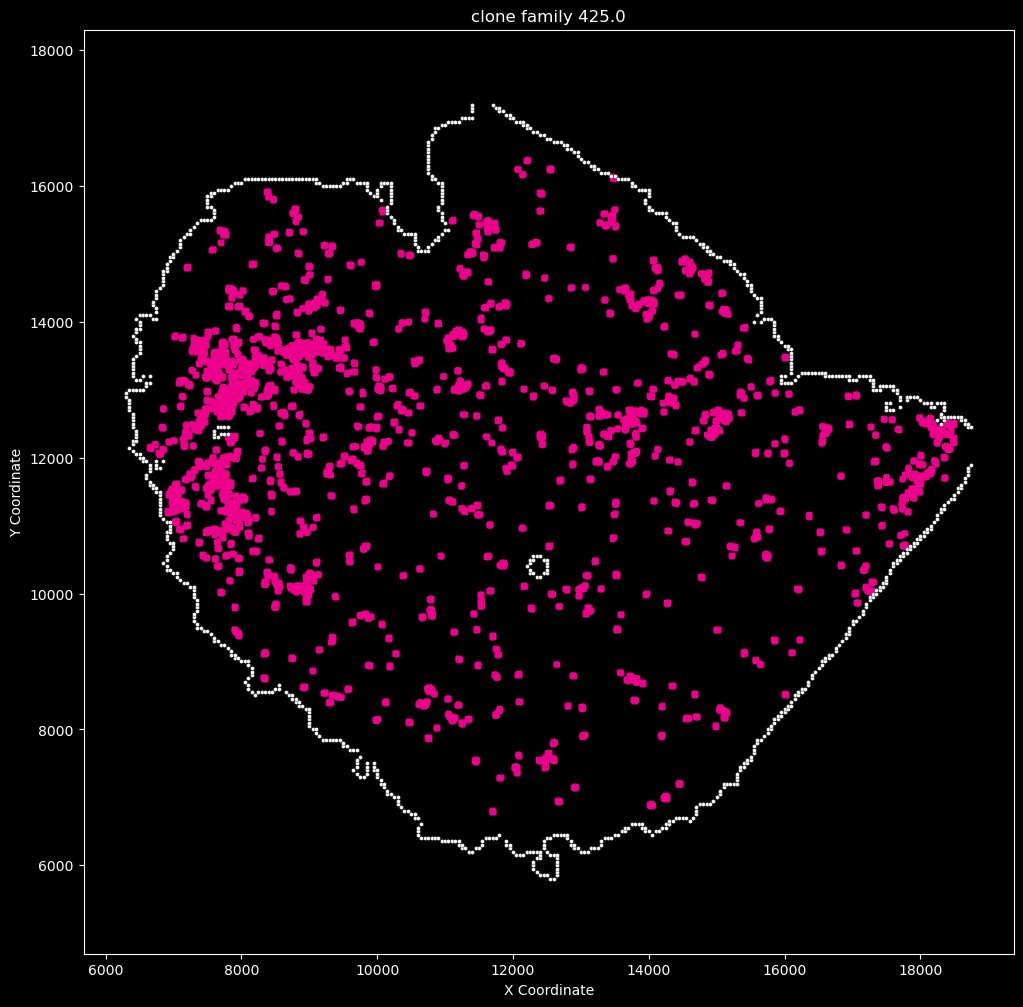

Overview image saved: /data1/fengyu/methods/zy/Review/for_github/fig2--ok/zhengli/fig2G_clone-expansion-family-425.0-overview.png

【STEP 5 | Zoom-in and smoothing】



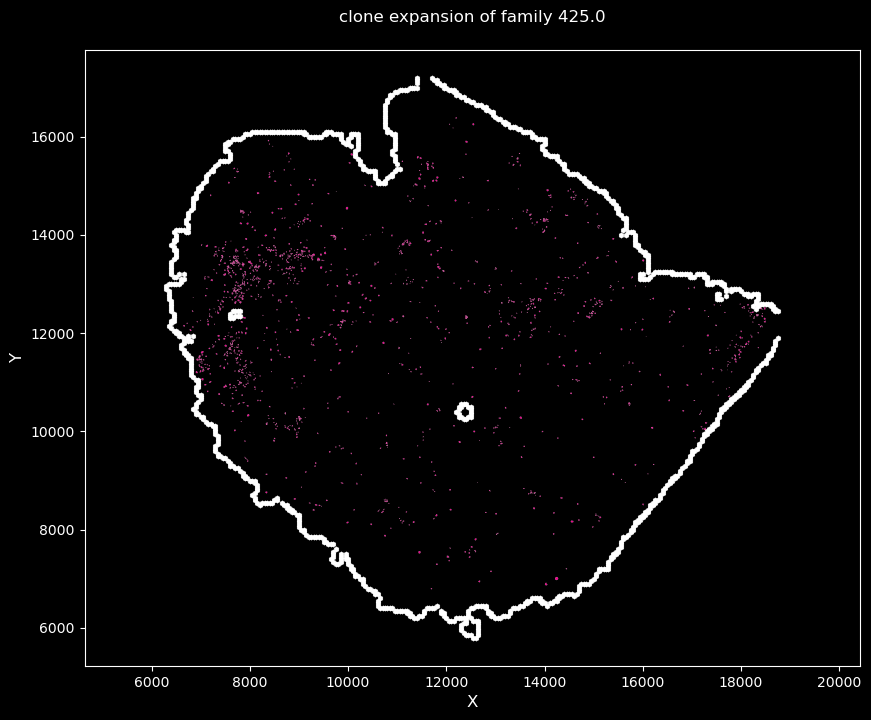

Zoom-in smoothed polygon image saved: /data1/fengyu/methods/zy/Review/for_github/fig2--ok/zhengli/fig2G_clone-expansion-family-425.0-zoomin.png

【Pipeline finished】

Total run time: 34.29 seconds


In [6]:
import scanpy as sc
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from matplotlib.patches import PathPatch
from matplotlib.path import Path
from matplotlib.collections import PatchCollection
from matplotlib.lines import Line2D
from scipy.interpolate import splprep, splev
import os
import time

def print_section(title):
    print("\n" + "="*60)
    print(f"【{title}】")
    print("="*60 + "\n")

# ==============================
# Path and parameter settings
# ==============================
DATA_PATH = '/data3/zhangyang/Method_Final_analysis/D06053D2/test_analysis_celltype/04.D06050D2_after_preprocess_Final.h5ad'
OUTDIR = '/data1/fengyu/methods/zy/Review/for_github/fig2--ok/zhengli/'
os.makedirs(OUTDIR, exist_ok=True)
family_id = 425.0   # You can choose other family IDs as needed
clone_expansion_color = '#ed008c'
EDGE_COLOR = 'white'

if __name__ == "__main__":
    start_time = time.time()
    print_section("STEP 1 | Reading AnnData object")
    adata = sc.read_h5ad(DATA_PATH)
    adata.obs['cellID'] = adata.obs['cellID'].astype(int)
    print("AnnData loaded and cellID processed.")

    print_section("STEP 2 | Preprocessing spatial border data")
    # Process cell border data
    cell_border = adata.obsm['cell_border']
    array_2d = cell_border.reshape(-1, cell_border.shape[-1])
    df = pd.DataFrame(array_2d)
    df['cellID'] = df.index // 32
    df['cellID'] = df['cellID'].astype(int)
    df.rename(columns={0:'x', 1:'y'}, inplace=True)
    df_filtered = df[(df['x'] != 32767) & (df['y'] != 32767)].copy()
    df_filtered['cellID'] = df_filtered['cellID'].astype(int)
    df_filtered = pd.merge(df_filtered, adata.obs[['x', 'y', 'cellID']], on='cellID', how='left')
    df_filtered['x'] = df_filtered['x_x'] + df_filtered['x_y']
    df_filtered['y'] = df_filtered['y_x'] + df_filtered['y_y']
    df_cellborder = df_filtered[['cellID', 'x', 'y']]
    tissue_outline = pd.DataFrame(adata.uns['tissue_outline'], columns=['x', 'y'])
    print("Spatial localization preprocessing complete.")

    print_section("STEP 3 | Select family & extract borders")
    family_cells = adata.obs[adata.obs['clone_family_id'] == family_id].reset_index()
    family_cells['cellID'] = family_cells['cellID'].astype(int)
    df_cellborder['cellID'] = df_cellborder['cellID'].astype(int)
    # Only extract the family cell borders
    family_cellborder = df_cellborder[df_cellborder['cellID'].isin(family_cells['cellID'])]
    # Group by each cell, convert borders to a list
    family_cellborder_list = (
        family_cellborder
        .groupby('cellID')
        .apply(lambda group: [[x, y] for x, y in zip(group['x'], group['y'])])
        .tolist()
    )
    # Convert each border to numpy array
    family_cellborder_list = [np.array(cell) for cell in family_cellborder_list]
    print(f"Number of family cells: {len(family_cellborder_list)}")

    # ================
    print_section("STEP 4 | Overview plotting")
    plt.style.use('dark_background')
    fig, ax = plt.subplots(figsize=(12, 12))
    fig.patch.set_facecolor('black')
    ax.set_facecolor('black')

    ax.scatter(
        family_cellborder['x'], family_cellborder['y'],
        color=clone_expansion_color, s=10, marker='s'
    )

    sns.scatterplot(
        x='x', y='y', data=tissue_outline,
        color=EDGE_COLOR, marker='h', s=10,
        edgecolor='black', linewidth=0.2, ax=ax
    )

    ax.set_xlim(0, 32768)
    ax.set_ylim(0, 32768)
    ax.grid(False)
    ax.axis('equal')
    ax.set_xlabel("X Coordinate", color='white')
    ax.set_ylabel("Y Coordinate", color='white')
    ax.set_title(f'clone family {family_id}', color='white')

    outpath1 = os.path.join(OUTDIR, f'fig2G_clone-expansion-family-{family_id}-overview.png')
    plt.savefig(outpath1, dpi=600, bbox_inches='tight', facecolor='black', transparent=False)
    plt.show(fig)
    print(f"Overview image saved: {outpath1}")

    # ================
    print_section("STEP 5 | Zoom-in and smoothing")
    plt.style.use('dark_background')
    fig, ax = plt.subplots(figsize=(10, 8))
    fig.patch.set_facecolor('black')
    ax.set_facecolor('black')
    patches = []

    def smooth_boundary(boundary, smoothness=0.5):
        x = boundary[:, 0]
        y = boundary[:, 1]
        x = np.append(x, x[0])
        y = np.append(y, y[0])
        tck, u = splprep([x, y], s=smoothness * len(x), per=True)
        u_new = np.linspace(u.min(), u.max(), 100)
        x_new, y_new = splev(u_new, tck, der=0)
        return np.column_stack((x_new, y_new))

    for idx, cell_boundary in enumerate(family_cellborder_list, start=1):
        if cell_boundary.shape[0] < 3:
            continue
        smoothed_boundary = smooth_boundary(cell_boundary, smoothness=0.5)
        vertices = smoothed_boundary
        codes = [Path.LINETO] * len(vertices)
        codes[0] = Path.MOVETO
        codes[-1] = Path.CLOSEPOLY

        path = Path(vertices, codes)
        patch = PathPatch(
            path,
            facecolor=clone_expansion_color,
            edgecolor='white',
            lw=0.1,
            antialiased=True
        )
        patches.append(patch)

    if patches:
        ax.add_collection(PatchCollection(patches, match_original=True))

    sns.scatterplot(
        x='x', y='y', data=tissue_outline,
        color='white', marker='h', s=15,
        edgecolor='white', ax=ax
    )
    ax.set_xlim(0, 40000)
    ax.set_ylim(0, 40000)
    ax.set_xlabel("X", color='white', fontsize=12)
    ax.set_ylabel("Y", color='white', fontsize=12)
    for spine in ax.spines.values():
        spine.set_color('white')
    ax.tick_params(axis='both', colors='white')
    ax.grid(False)
    ax.axis('equal')
    ax.set_title(f"clone expansion of family {family_id}", color='white', pad=20)

    outpath2 = os.path.join(OUTDIR, f'fig2G_clone-expansion-family-{family_id}-zoomin.png')
    plt.savefig(outpath2, dpi=2500, bbox_inches='tight', facecolor='black', transparent=False)
    plt.show(fig)
    print(f"Zoom-in smoothed polygon image saved: {outpath2}")

    print_section("Pipeline finished")
    end_time = time.time()
    print(f'Total run time: {end_time - start_time:.2f} seconds')

# fig2H

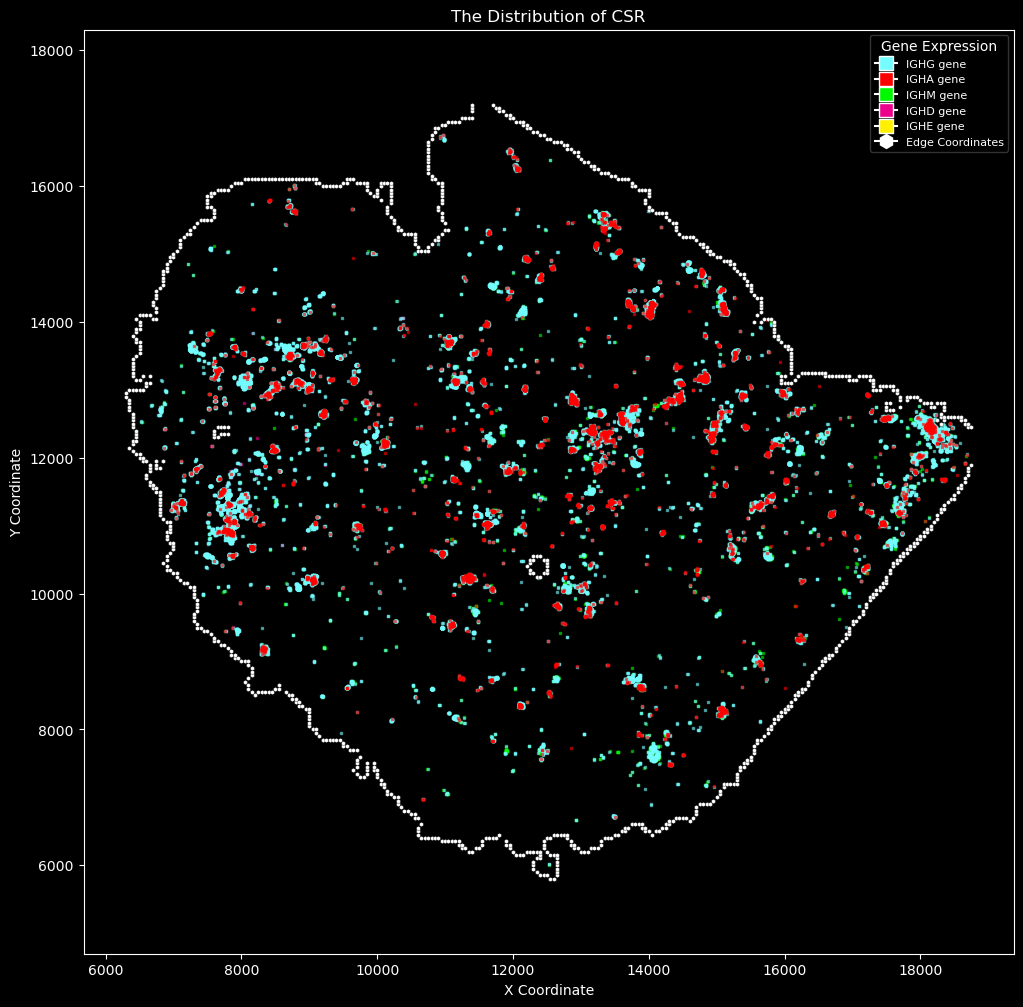

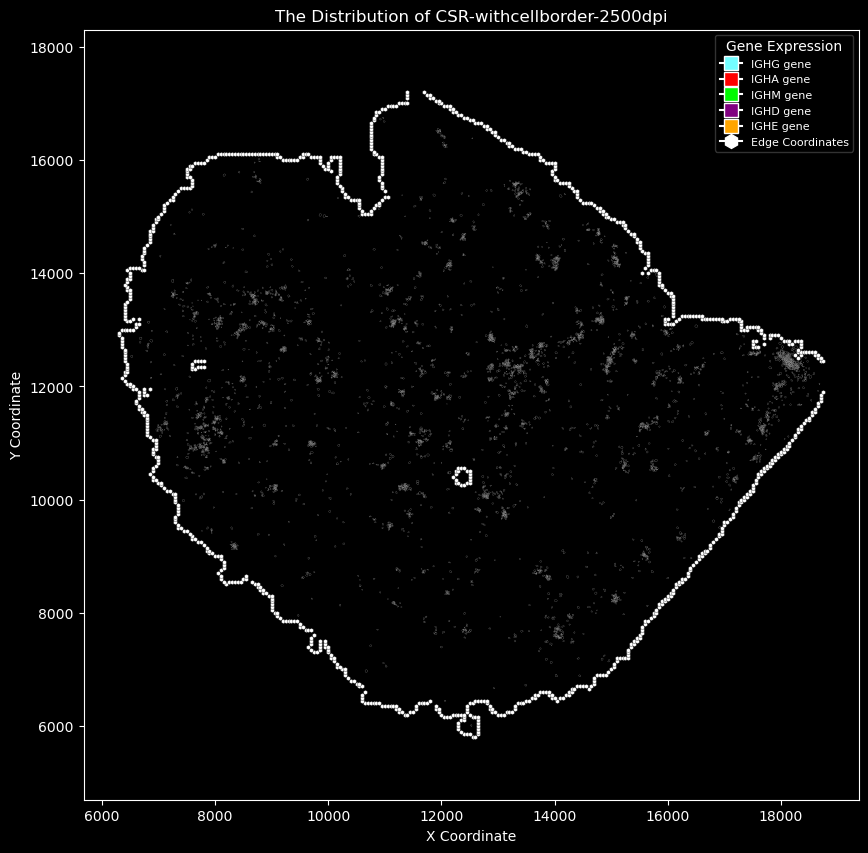

In [10]:
import scanpy as sc
import pandas as pd
import numpy as np
from shapely.geometry import Point, Polygon
from shapely.strtree import STRtree
import matplotlib.pyplot as plt
from matplotlib.lines import Line2D
from matplotlib.path import Path
from matplotlib.patches import PathPatch
from matplotlib.collections import PatchCollection
import seaborn as sns
from scipy.interpolate import splprep, splev
from tqdm import tqdm

# --- 1. Data loading and preprocessing ---

# 1.1 Read spatial transcriptomics AnnData object and tissue outline
adata = sc.read_h5ad('/data3/zhangyang/Method_Final_analysis/D06053D2/test_analysis_celltype/04.D06050D2_after_preprocess_Final.h5ad')
tissue_outline = pd.DataFrame(adata.uns['tissue_outline'], columns=['x', 'y'])

# 1.2 Process cell border information
array_2d = adata.obsm['cell_border'].reshape(-1, adata.obsm['cell_border'].shape[-1])
df = pd.DataFrame(array_2d)
df['cellID'] = df.index // 32
df['cellID'] = df['cellID'].astype(str)
df.rename(columns={0: 'x', 1: 'y'}, inplace=True)
df_filtered = df[(df['x'] != 32767) & (df['y'] != 32767)].copy()
df_filtered['cellID'] = df_filtered['cellID'].astype(int)
# Merge with cell spatial location information
df_filtered = pd.merge(df_filtered, adata.obs[['x', 'y', 'cellID']], on='cellID', how='left')
df_filtered['x'] = df_filtered['x_x'] + df_filtered['x_y']
df_filtered['y'] = df_filtered['y_x'] + df_filtered['y_y']
df_cellborder = df_filtered[['cellID', 'x', 'y']]

# 1.3 Read gene expression matrix
gem = pd.read_csv('/data3/zhanxiaojuan/03.LC/00.raw_data/stereo_gef_gem_h5ad/D06053D2/D06053D2.cellbin.gem', sep='\t', comment='#')

# --- 2. Extract CSR-labeled cells and related borders ---
CSR_row = adata.obs[adata.obs['CSR'] == 'yes']
CSR_row_cellid = CSR_row['cellID'].astype(int)
CSR_row_border = df_cellborder[df_cellborder['cellID'].isin(CSR_row_cellid)]

# --- 3. Extract points corresponding to target (IGH-type) genes ---

target_genes = ['IGHG1', 'IGHG2', 'IGHG3', 'IGHG4', 'IGHA1', 'IGHA2', 'IGHM', 'IGHD', 'IGHE']
target_genes = [gene.upper() for gene in target_genes]
all_IGH_gene = gem[gem['geneName'].isin(target_genes)]

# --- 4. Spatial mapping: Allocate gene points to cells ---

# 4.1 Build CSR cell border polygons
polygons = CSR_row_border.groupby('cellID').apply(
    lambda group: Polygon(zip(group['x'], group['y']))
).reset_index(name='polygon')

# 4.2 Create spatial index
spatial_index = STRtree(polygons['polygon'])
polygons = polygons.reset_index(drop=True)  # Ensure the index is consistent

# 4.3 Convert expression points to Point objects
all_IGH_gene = all_IGH_gene.copy()
all_IGH_gene['point'] = all_IGH_gene.apply(lambda row: Point(row['x'], row['y']), axis=1)

def find_cellID(point, polygons, spatial_index):
    """Given a spatial index, find the cellID that contains the point"""
    possible_matches_index = list(spatial_index.query(point))
    possible_matches = polygons.iloc[possible_matches_index]
    for _, row in possible_matches.iterrows():
        if row['polygon'].intersects(point):
            return row['cellID']
    return None

def assign_gene_to_cell(df_gene, polygons, spatial_index):
    df_gene = df_gene.copy()
    df_gene['cellID'] = df_gene['point'].apply(lambda pt: find_cellID(pt, polygons, spatial_index))
    return df_gene

# 4.4 Map each IG gene point to cellID
IGH_gene_assigned = assign_gene_to_cell(all_IGH_gene, polygons, spatial_index)
IGH_gene_assigned = IGH_gene_assigned.dropna(subset=['cellID'])
IGH_gene_assigned['cellID'] = IGH_gene_assigned['cellID'].astype(int)

# 4.5 Only keep expression points within CSR cells
CSR_gene = IGH_gene_assigned[IGH_gene_assigned['cellID'].isin(CSR_row_cellid)]
CSR_gene['tmp'] = CSR_gene['geneName'].str[:4]

# --- 5. Plot: CSR overview distribution ---

def plot_CSR_overview(CSR_gene, CSR_row_border, tissue_outline, output_path='fig2H_The_Distribution_of_CSR_overview.png', dpi=600):
    # Colors
    IGHG_color = '#73FDFF'
    IGHA_color = 'red'
    IGHM_color = '#00F900'
    IGHD_color = '#ed008c'
    IGHE_color = '#fff000'
    EDGE_COLOR = 'white'

    plt.style.use('dark_background')
    fig, ax = plt.subplots(figsize=(12, 12))
    fig.patch.set_facecolor('black')
    ax.set_facecolor('black')

    # Scatter plot for gene expression
    ax.scatter(CSR_gene[CSR_gene['tmp'] == 'IGHM']['x'], CSR_gene[CSR_gene['tmp'] == 'IGHM']['y'], color=IGHM_color, s=1, alpha=0.5, marker='s')
    ax.scatter(CSR_gene[CSR_gene['tmp'] == 'IGHD']['x'], CSR_gene[CSR_gene['tmp'] == 'IGHD']['y'], color=IGHD_color, s=1, alpha=0.5, marker='s')
    ax.scatter(CSR_gene[CSR_gene['tmp'] == 'IGHE']['x'], CSR_gene[CSR_gene['tmp'] == 'IGHE']['y'], color=IGHE_color, s=1, alpha=0.5, marker='s')
    ax.scatter(CSR_gene[CSR_gene['tmp'] == 'IGHG']['x'], CSR_gene[CSR_gene['tmp'] == 'IGHG']['y'], color=IGHG_color, s=1, alpha=0.5, marker='s')
    ax.scatter(CSR_gene[CSR_gene['tmp'] == 'IGHA']['x'], CSR_gene[CSR_gene['tmp'] == 'IGHA']['y'], color=IGHA_color, s=1, alpha=0.5, marker='s')

    # Tissue outline scatter
    sns.scatterplot(x='x', y='y', data=tissue_outline, color=EDGE_COLOR, marker='h', s=10,
                   edgecolor='black', linewidth=0.2, ax=ax)

    # Axis and title
    ax.set_xlim(0, 32768)
    ax.set_ylim(0, 32768)
    ax.axis('equal')
    ax.grid(False)
    ax.set_title("The Distribution of CSR", color='white')
    ax.set_xlabel("X Coordinate", color='white')
    ax.set_ylabel("Y Coordinate", color='white')

    # Legend
    legend_elements = [
        Line2D([0], [0], marker='s', color='w', label='IGHG gene', markerfacecolor=IGHG_color, markersize=10),
        Line2D([0], [0], marker='s', color='w', label='IGHA gene', markerfacecolor=IGHA_color, markersize=10),
        Line2D([0], [0], marker='s', color='w', label='IGHM gene', markerfacecolor=IGHM_color, markersize=10),
        Line2D([0], [0], marker='s', color='w', label='IGHD gene', markerfacecolor=IGHD_color, markersize=10),
        Line2D([0], [0], marker='s', color='w', label='IGHE gene', markerfacecolor=IGHE_color, markersize=10),
        Line2D([0], [0], marker='h', color='w', label='Edge Coordinates', markerfacecolor=EDGE_COLOR, markersize=10),
    ]
    legend = ax.legend(handles=legend_elements, loc='upper right', frameon=True, framealpha=0.2,
                      facecolor='black', edgecolor='white', fontsize=8,
                      title='Gene Expression', title_fontsize=10)
    plt.setp(legend.get_texts(), color='white')

    plt.savefig(output_path, dpi=dpi, bbox_inches='tight', facecolor='black', transparent=False)
    plt.show()

plot_CSR_overview(CSR_gene, CSR_row_border, tissue_outline)

# --- 6. Plot: High-res zoom view with cell borders ---

def smooth_boundary(boundary, smoothness=0.5):
    """Input n x 2, return smoothed boundary points"""
    x = boundary[:, 0]
    y = boundary[:, 1]
    x = np.append(x, x[0])
    y = np.append(y, y[0])
    tck, u = splprep([x, y], s=smoothness * len(x), per=True)
    u_new = np.linspace(u.min(), u.max(), 100)
    x_new, y_new = splev(u_new, tck, der=0)
    return np.column_stack((x_new, y_new))

def plot_CSR_with_cellborder(
    CSR_gene, CSR_row_border, tissue_outline, output_path='fig2H_The_Distribution_of_CSR_zoomin.png', dpi=2500
):
    # Colors
    IGHG_color = '#73FDFF'
    IGHA_color = 'red'
    IGHM_color = '#00F900'
    IGHD_color = 'purple'
    IGHE_color = 'orange'
    EDGE_COLOR = 'white'
    dot_size = 0.01  # Smaller than border line width, to emphasize outline

    plt.style.use('dark_background')
    fig, ax = plt.subplots(figsize=(10, 10))
    fig.patch.set_facecolor('black')
    ax.set_facecolor('black')

    # Get complete border of each cell
    cell_borders = CSR_row_border.groupby('cellID').apply(lambda group: group[['x', 'y']].values).tolist()

    # Add cell boundary PathPatch
    patches = []
    for cell_boundary in cell_borders:
        if len(cell_boundary) < 3:
            continue
        smoothed = smooth_boundary(cell_boundary, smoothness=0.5)
        codes = [Path.LINETO] * len(smoothed)
        codes[0] = Path.MOVETO
        codes[-1] = Path.CLOSEPOLY
        path = Path(smoothed, codes)
        patch = PathPatch(path, edgecolor=EDGE_COLOR, facecolor='none', linewidth=0.1)
        patches.append(patch)
    ax.add_collection(PatchCollection(patches, match_original=True))

    # Tissue outline scatter
    sns.scatterplot(x='x', y='y', data=tissue_outline, color=EDGE_COLOR, marker='h', s=10,
                   edgecolor='black', linewidth=0.2, ax=ax)

    # Gene expression points (very small size)
    sns.scatterplot(x=CSR_gene[CSR_gene['tmp'] == 'IGHG']['x'], y=CSR_gene[CSR_gene['tmp'] == 'IGHG']['y'], color=IGHG_color, s=dot_size, marker='s', ax=ax)
    sns.scatterplot(x=CSR_gene[CSR_gene['tmp'] == 'IGHA']['x'], y=CSR_gene[CSR_gene['tmp'] == 'IGHA']['y'], color=IGHA_color, s=dot_size, marker='s', ax=ax)
    sns.scatterplot(x=CSR_gene[CSR_gene['tmp'] == 'IGHM']['x'], y=CSR_gene[CSR_gene['tmp'] == 'IGHM']['y'], color=IGHM_color, s=dot_size, marker='s', ax=ax)
    sns.scatterplot(x=CSR_gene[CSR_gene['tmp'] == 'IGHD']['x'], y=CSR_gene[CSR_gene['tmp'] == 'IGHD']['y'], color=IGHD_color, s=dot_size, marker='s', ax=ax)
    sns.scatterplot(x=CSR_gene[CSR_gene['tmp'] == 'IGHE']['x'], y=CSR_gene[CSR_gene['tmp'] == 'IGHE']['y'], color=IGHE_color, s=dot_size, marker='s', ax=ax)

    # Axis and title
    ax.set_xlim(0, 32768)
    ax.set_ylim(0, 32768)
    ax.axis('equal')
    ax.grid(False)
    ax.set_title("The Distribution of CSR-withcellborder-2500dpi", color='white')
    ax.set_xlabel("X Coordinate", color='white')
    ax.set_ylabel("Y Coordinate", color='white')

    # Legend
    legend_elements = [
        Line2D([0], [0], marker='s', color='w', label='IGHG gene', markerfacecolor=IGHG_color, markersize=10),
        Line2D([0], [0], marker='s', color='w', label='IGHA gene', markerfacecolor=IGHA_color, markersize=10),
        Line2D([0], [0], marker='s', color='w', label='IGHM gene', markerfacecolor=IGHM_color, markersize=10),
        Line2D([0], [0], marker='s', color='w', label='IGHD gene', markerfacecolor=IGHD_color, markersize=10),
        Line2D([0], [0], marker='s', color='w', label='IGHE gene', markerfacecolor=IGHE_color, markersize=10),
        Line2D([0], [0], marker='h', color='w', label='Edge Coordinates', markerfacecolor=EDGE_COLOR, markersize=10),
    ]
    legend = ax.legend(handles=legend_elements, loc='upper right', frameon=True, framealpha=0.2,
                      facecolor='black', edgecolor='white', fontsize=8,
                      title='Gene Expression', title_fontsize=10)
    plt.setp(legend.get_texts(), color='white')

    plt.savefig(output_path, dpi=dpi, bbox_inches='tight', facecolor='black', transparent=False)
    plt.show()

plot_CSR_with_cellborder(CSR_gene, CSR_row_border, tissue_outline)

# fig2I

/home/fengyu/miniconda3/envs/st/lib/python3.8/site-packages/geopandas/_compat.py:124: UserWarning: The Shapely GEOS version (3.12.2-CAPI-1.18.2) is incompatible with the GEOS version PyGEOS was compiled with (3.10.4-CAPI-1.16.2). Conversions between both will be slow.
  warnings.warn(


Using coords from: spatial, shape=(10785, 2)


/tmp/ipykernel_90359/1047609396.py:88: ImplicitModificationWarning: Trying to modify attribute `.obs` of view, initializing view as actual.
  adata.obs['local_cdr3_match_count'] = y
/home/fengyu/miniconda3/envs/st/lib/python3.8/site-packages/esda/getisord.py:615: UserWarning: Gi* requested, but (a) weights are already row-standardized, (b) no weights are on the diagonal, and (c) no default value supplied to star. Assuming that the self-weight is equivalent to the maximum weight in the row. To use a different default (like, .5), set `star=.5`, or use libpysal.weights.fill_diagonal() to set the diagonal values of your weights matrix and use `star=None` in Gi_Local.
  warnings.warn(



=== More beautiful colorbar layout ===


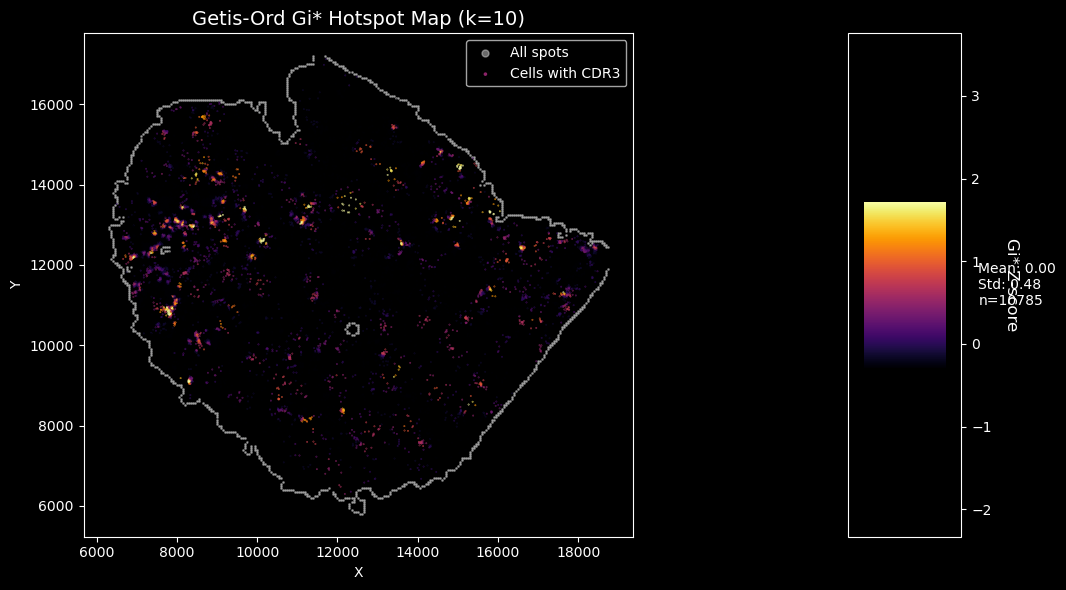

In [11]:
import numpy as np
import pandas as pd
import scanpy as sc
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import zscore
from sklearn.neighbors import NearestNeighbors
from libpysal.weights import KNN as W_KNN
from esda.getisord import G_Local  # Getis-Ord G/G*

# ---------- Data Loading ----------
adata = sc.read_h5ad('/data3/zhangyang/Method_Final_analysis/D06053D2/test_analysis_celltype/04.D06050D2_after_preprocess_Final.h5ad')
adata = adata[adata.obs['IGHcdr3aa'].notna()]
OUTDIR = '/data1/fengyu/methods/zy/Review/for_github/fig2--ok/zhengli/fig2M.png'
tissue = pd.DataFrame(adata.uns['tissue_outline'], columns=['x', 'y'])

# ---------- Get coordinates (prefer true spatial coordinates) ----------
def get_coords(adata):
    # Priority: spatial coordinates (e.g. Visium)
    if 'spatial' in adata.obsm:
        coords = adata.obsm['spatial'][:, :2]
        return coords, 'spatial'
    # Fallback: previously aligned UMAP coordinates
    if 'X_umap' in adata.obsm:
        coords = adata.obsm['X_umap'][:, :2]
        return coords, 'X_umap'
    # If available as columns in obs
    for pair in (('x', 'y'), ('X', 'Y'), ('umap_X', 'umap_Y')):
        if set(pair).issubset(adata.obs.columns):
            return adata.obs[list(pair)].values, f'obs:{pair}'
    raise ValueError("No spatial coordinate found (obsm['spatial'], obsm['X_umap'], or obs x/y columns).")

coords, coord_source = get_coords(adata)
print(f'Using coords from: {coord_source}, shape={coords.shape}')

# ---------- Settings ----------
seq_col = 'IGHcdr3aa'   # CDR3 amino acid sequence column (in adata.obs)
k_neighbors = 10        # KNN neighbors for y and Gi* weights
use_similarity_threshold = True # Use similarity (edit distance)
levenshtein_threshold =  1      # Similarity threshold (max edit distance)

# ---------- KNN construction ----------
nbrs = NearestNeighbors(n_neighbors=k_neighbors+1, algorithm='auto').fit(coords)
distances, indices = nbrs.kneighbors(coords)

# ---------- Get sequence values ----------
seqs = adata.obs[seq_col].astype('object').values
seqs = np.array([s if (isinstance(s, str) and len(s) > 0) else None for s in seqs], dtype=object)

# ---------- Define Levenshtein edit distance ----------
def levenshtein(a, b):
    if a is None or b is None:
        return 10**9  # treat as very large distance
    if a == b:
        return 0
    la, lb = len(a), len(b)
    if la == 0: return lb
    if lb == 0: return la
    dp = list(range(lb+1))
    for i in range(1, la+1):
        prev = dp[0]
        dp[0] = i
        for j in range(1, lb+1):
            tmp = dp[j]
            cost = 0 if a[i-1] == b[j-1] else 1
            dp[j] = min(dp[j] + 1,       # deletion
                        dp[j-1] + 1,     # insertion
                        prev + cost)     # substitution
            prev = tmp
    return dp[lb]

# ---------- Compute "local similarity count" y for each cell ----------
y = np.zeros(len(seqs), dtype=float)
for i in range(len(seqs)):
    neigh = indices[i, 1:]  # drop self
    s_i = seqs[i]
    if s_i is None:
        y[i] = 0
        continue
    if use_similarity_threshold:
        y[i] = sum(
            1 for j in neigh
            if seqs[j] is not None and 0 < levenshtein(s_i, seqs[j]) <= levenshtein_threshold
        )
    else:
        y[i] = sum(1 for j in neigh if seqs[j] == s_i)

adata.obs['local_cdr3_match_count'] = y

# Validate data integrity
if np.all(np.isnan(y)):
    raise ValueError("All local CDR3 similarity counts (local_cdr3_match_count) are NaN, no valid data!")
if y.shape[0] != coords.shape[0]:
    raise ValueError("y and coords length inconsistent!")

# ---------- Use libpysal + esda to compute Getis-Ord G* ----------
w = W_KNN(coords, k=k_neighbors)
g_local = G_Local(y, w, star=True, permutations=0)
zs = getattr(g_local, 'Zs', None)
if zs is None:
    zs = getattr(g_local, 'z_sim', None)
if zs is None:
    zs = zscore(getattr(g_local, 'G_local', getattr(g_local, 'G', y)))
pdata = getattr(g_local, 'p_sim', None)

zs = np.asarray(zs, dtype=float)  # Explicitly convert to float array

adata.obs['GiZ'] = zs
df = adata.obs
if pdata is not None:
    adata.obs['Gi_p'] = pdata

# ---------- Filter out NaN and inf for plotting ----------
good_mask = np.isfinite(zs) & np.isfinite(coords[:, 0]) & np.isfinite(coords[:, 1])
if not np.all(good_mask):
    print(f"Warning: {np.sum(~good_mask)} points have invalid Gi* or coordinates, filtered for plotting!")

zs_plot = zs[good_mask]
coords_plot = coords[good_mask, :]
n_cells = zs_plot.shape[0]

# ---------- Plotting ----------
print("\n=== More beautiful colorbar layout ===")
plt.style.use('dark_background')
fig, axes = plt.subplots(1, 2, figsize=(14, 6), gridspec_kw={'width_ratios': [12, 1]})

axes[0].scatter(tissue['x'], tissue['y'], s=1, color='lightgray', alpha=0.5, label='All spots')

if n_cells == 0:
    raise ValueError('No cells available for plotting! (All Gi* are NaN or data broken)')

vmin = np.nanpercentile(zs_plot, 1)
vmax = np.nanpercentile(zs_plot, 99)
im = axes[0].scatter(coords_plot[:,0], coords_plot[:,1], c=zs_plot, s=0.1, cmap='inferno',
                     vmin=vmin, vmax=vmax, label='Cells with CDR3')
axes[0].set_title(f'Getis-Ord Gi* Hotspot Map (k={k_neighbors})', fontsize=14)
axes[0].set_xlabel('X'); axes[0].set_ylabel('Y')
axes[0].set_aspect('equal')
axes[0].legend(loc='upper right', markerscale=5)

cbar = fig.colorbar(im, cax=axes[1], orientation='vertical')
cbar.set_label('Gi* Z-score', fontsize=12, rotation=270, labelpad=20)
mean_z = np.nanmean(zs_plot)
std_z = np.nanstd(zs_plot)
axes[1].text(1.15, 0.5, f'Mean: {mean_z:.2f}\nStd: {std_z:.2f}\nn={n_cells}',
             transform=axes[1].transAxes, fontsize=10, verticalalignment='center', horizontalalignment='left')
plt.axis('equal')
plt.grid(False)
plt.tight_layout()
plt.savefig(OUTDIR,dpi = 900)
plt.show()

# fig2J


【Step 1 | 数据加载和样本选择】


【Step 2 | 作图: family 340 主要分型散点分布】



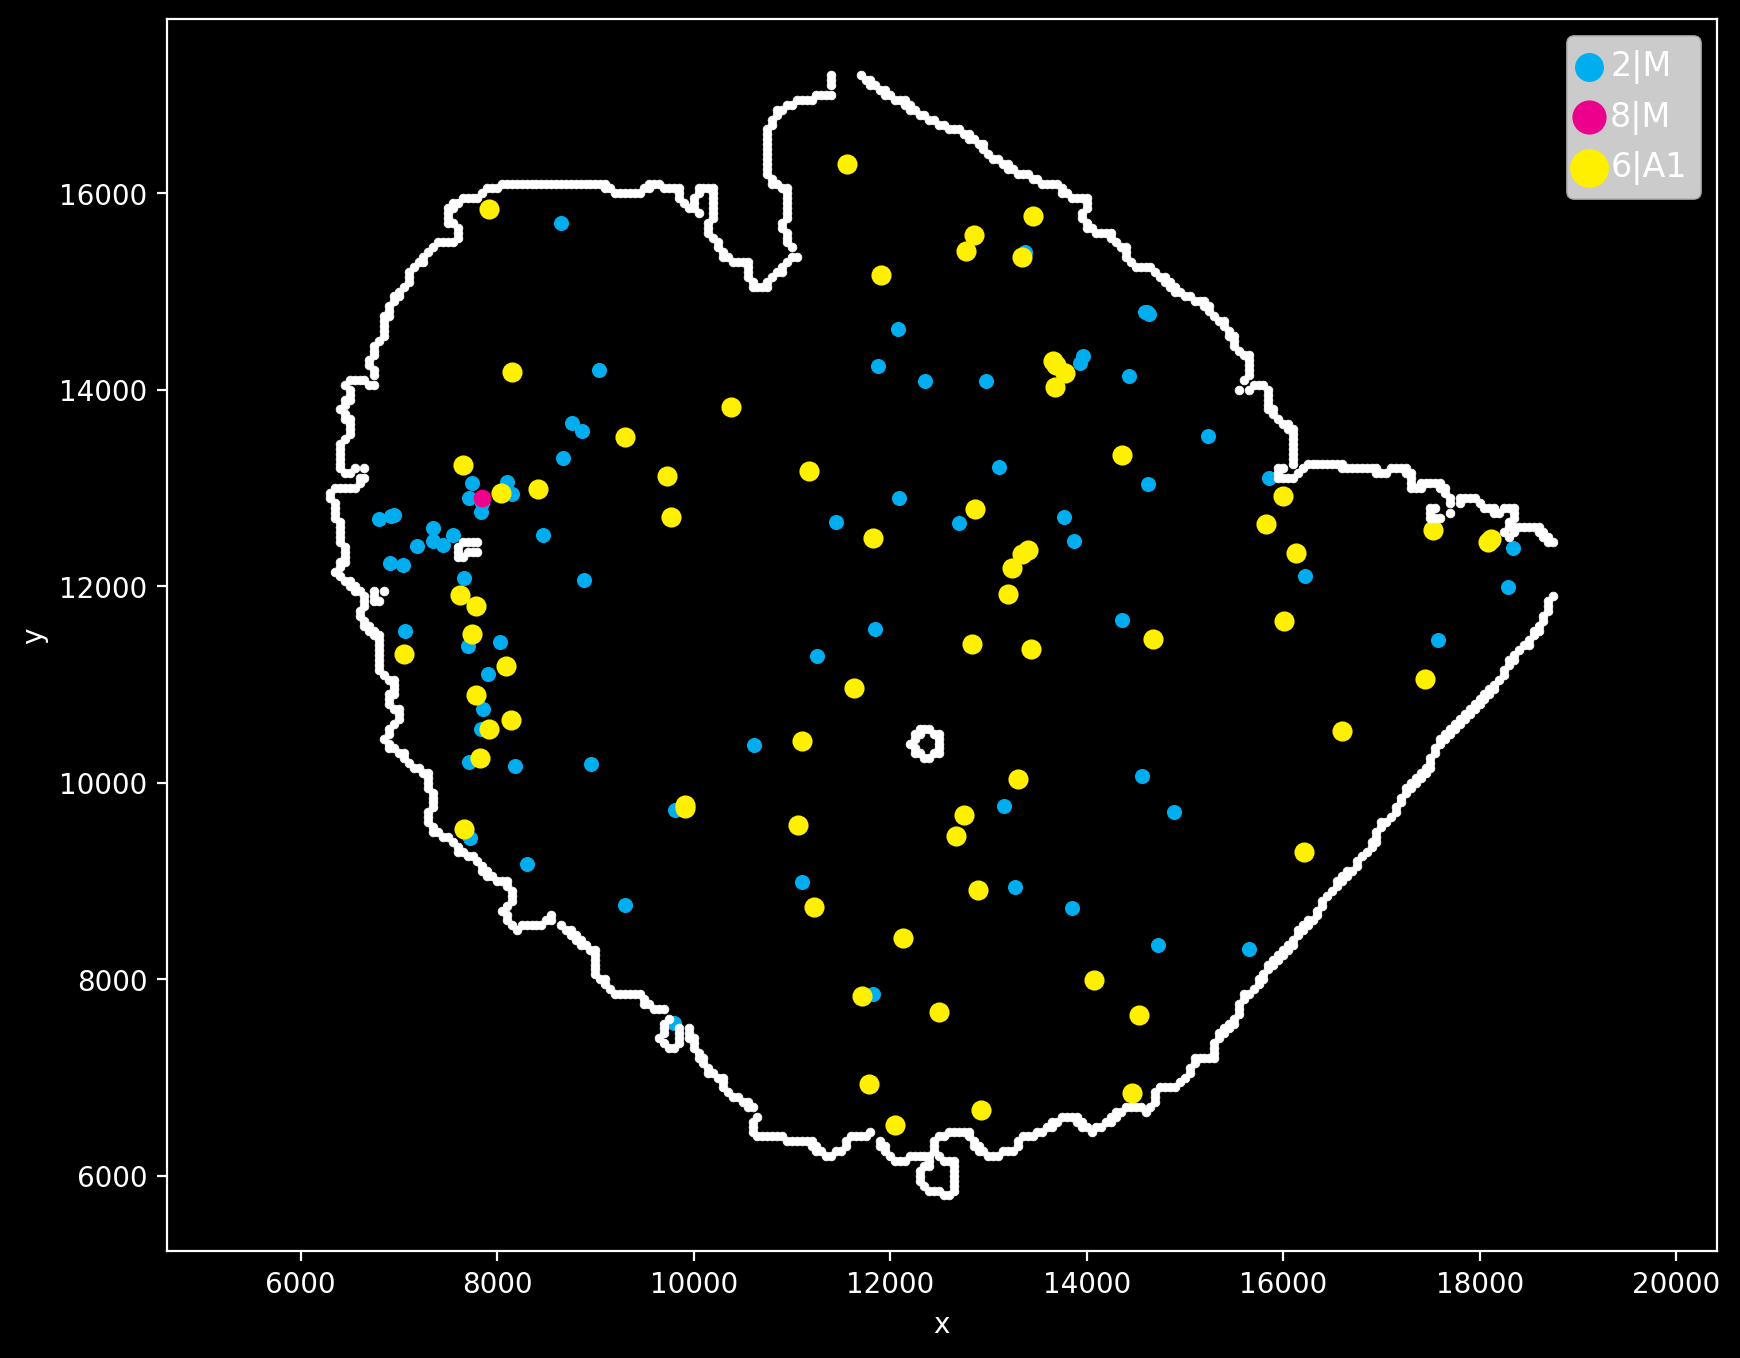

✔️ family-340-scatter_plot 已保存: /data1/fengyu/methods/zy/Review/for_github/fig2--ok/zhengli/family-340-scatter_plot.pdf

【Step 3 | 2|M clone expansion Patch 边界可视化】



/tmp/ipykernel_90359/4010738716.py:92: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  clone_expansion['cellID'] = clone_expansion['cellID'].astype(int)


✔️ Clone expansion Patch 已保存: /data1/fengyu/methods/zy/Review/for_github/fig2--ok/zhengli/fig2J_clone_expansion-family-340.png

【Step 4 | shm_j Patch分型】



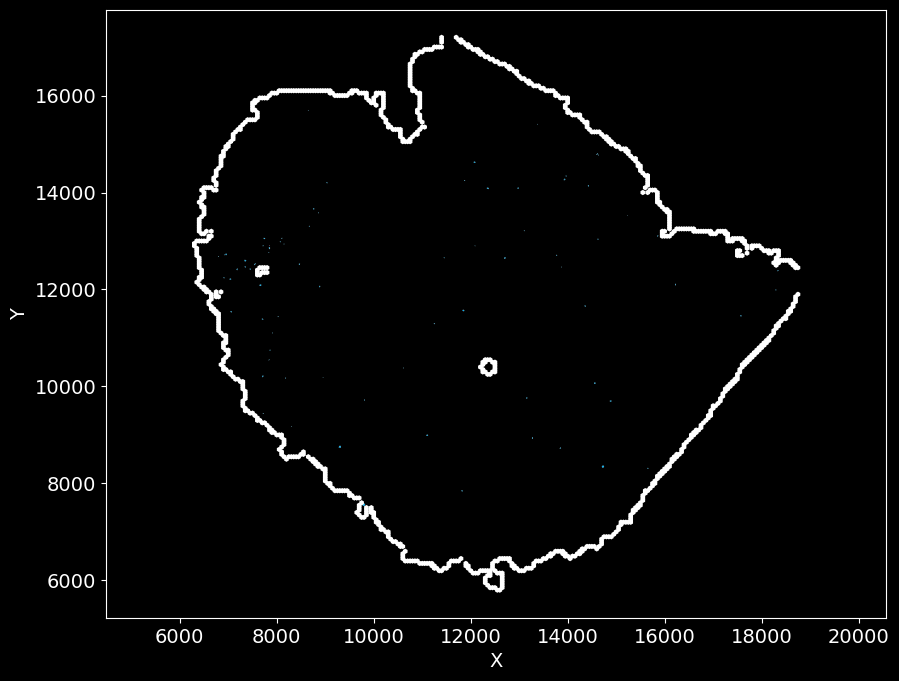

✔️ SHM型 Patch 已保存: /data1/fengyu/methods/zy/Review/for_github/fig2--ok/zhengli/fig2J_shm-family-340.png

【Step 5 | CSR Patch分型】



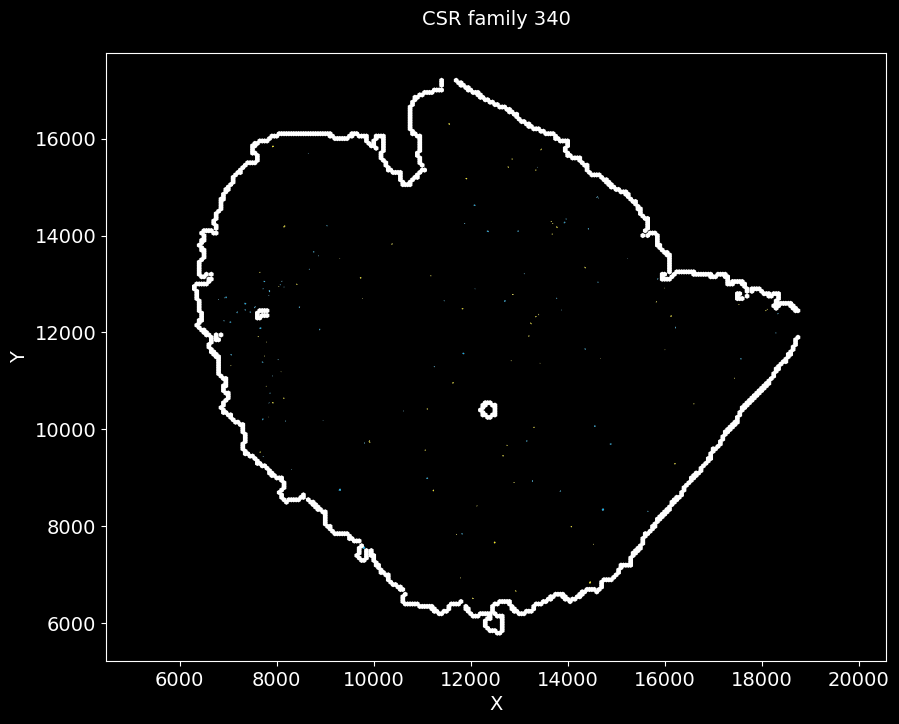

✔️ CSR型 Patch 已保存: /data1/fengyu/methods/zy/Review/for_github/fig2--ok/zhengli/fig2J_Class-switch-family-340.png

【流程结束 | Pipeline finished】

总运行时间: 72.95 秒 / 1.22 分钟


In [12]:
import scanpy as sc
import pandas as pd
import numpy as np
import os
import matplotlib.pyplot as plt
from matplotlib.patches import PathPatch, Patch
from matplotlib.path import Path
from matplotlib.collections import PatchCollection
import seaborn as sns
from scipy.interpolate import splprep, splev
import time

# ===================== 路径配置 =====================
DATA_PATH = '/data3/zhangyang/Method_Final_analysis/D06053D2/test_analysis_celltype/04.D06050D2_after_preprocess_Final.h5ad'
OUTDIR = '/data1/fengyu/methods/zy/Review/for_github/fig2--ok/zhengli/'
os.makedirs(OUTDIR, exist_ok=True)

def print_section(section):
    print('\n' + '=' * 60)
    print(f'【{section}】')
    print('=' * 60 + '\n')

def smooth_boundary(boundary, smoothness=0.5):
    x = boundary[:, 0]
    y = boundary[:, 1]
    x = np.append(x, x[0])
    y = np.append(y, y[0])
    tck, u = splprep([x, y], s=smoothness * len(x), per=True)
    u_new = np.linspace(u.min(), u.max(), 100)
    x_new, y_new = splev(u_new, tck, der=0)
    return np.column_stack((x_new, y_new))

def main():
    t0 = time.time()
    print_section('Step 1 | 数据加载和样本选择')
    adata = sc.read_h5ad(DATA_PATH)
    adata.obs['label'] = adata.obs['label'].astype(str)
    df = adata.obs
    tissue_outline = pd.DataFrame(adata.uns['tissue_outline'], columns=['x', 'y'])
    scatter = adata.obs[adata.obs['clone_family_id'] == 340.0]
    scatter = scatter[(scatter['label'] == '2|M') | (scatter['label'] == '8|M') | (scatter['label'] == '6|A1')]

    # ----------- (1) Clone scatter plot（所有label细胞空间分布） -----------
    print_section('Step 2 | 作图: family 340 主要分型散点分布')
    plt.style.use('dark_background')
    fig, ax = plt.subplots(figsize=(10, 8))
    def vector(on=False):
        if on:
            sc.set_figure_params(dpi=50, dpi_save=300, vector_friendly=False)
        else:
            sc.set_figure_params(dpi=50, dpi_save=300, vector_friendly=True)
    vector(False)
    sns.scatterplot(data=scatter[scatter['label'] == '2|M'],x='x', y='y',color='#00aeef', s=25, marker='o', label='2|M',edgecolor=None)  
    sns.scatterplot(data=scatter[scatter['label'] == '8|M'], x='x', y='y',color='#ed008c', s=35, marker='o',label='8|M',edgecolor=None)
    sns.scatterplot(data=scatter[scatter['label'] == '6|A1'], x='x', y='y',color='#fff000', s=45,marker='o',label='6|A1',edgecolor=None)
    sns.scatterplot(data=tissue_outline,x='x', y='y',color='white', s=10)
    plt.legend(
        fontsize=12,
        markerscale=2,
        frameon=True,
        title_fontsize='14',
        loc='upper right',
    )
    ax.spines['bottom'].set_color('white')
    ax.spines['left'].set_color('white')
    ax.tick_params(axis='x', colors='white')
    ax.tick_params(axis='y', colors='white')
    ax.xaxis.label.set_color('white')
    ax.yaxis.label.set_color('white')
    plt.gca().set_facecolor('black')
    ax.grid(False)
    ax.axis('equal')
    scatter_outfile = os.path.join(OUTDIR, "family-340-scatter_plot.pdf")
    plt.savefig(scatter_outfile, format='pdf', dpi=300, bbox_inches='tight')
    plt.show()
    print(f"✔️ family-340-scatter_plot 已保存: {scatter_outfile}")

    # ----------- (2) 2|M克隆空间patch ----------
    print_section('Step 3 | 2|M clone expansion Patch 边界可视化')
    adata.obs['cellID'] = adata.obs['cellID'].astype(int)
    array_2d = adata.obsm['cell_border'].reshape(-1, adata.obsm['cell_border'].shape[-1])
    df_cellborder = pd.DataFrame(array_2d)
    df_cellborder['cellID'] = df_cellborder.index // 32
    df_cellborder['cellID'] = df_cellborder['cellID'].astype(int)
    df_cellborder.rename(columns={0:'x', 1:'y'}, inplace=True)
    df_cellborder = df_cellborder[(df_cellborder['x'] != 32767) & (df_cellborder['y'] != 32767)]
    df_cellborder = pd.merge(df_cellborder, adata.obs[['x', 'y', 'cellID']], on='cellID', how='left')
    df_cellborder['x'] = df_cellborder['x_x'] + df_cellborder['x_y']
    df_cellborder['y'] = df_cellborder['y_x'] + df_cellborder['y_y']
    df_cellborder = df_cellborder[['cellID', 'x', 'y']]
    clone_expansion = scatter[scatter['label'] == '2|M']
    clone_expansion['cellID'] = clone_expansion['cellID'].astype(int)
    df_cellborder['cellID'] = df_cellborder['cellID'].astype(int)
    clone_expansion_border = df_cellborder[df_cellborder['cellID'].isin(clone_expansion['cellID'])]
    clone_expansion_border_list = clone_expansion_border.groupby('cellID').apply(lambda group: [[x, y] for x, y in zip(group['x'], group['y'])]).tolist()
    clone_expansion_border_list = [np.array(cell) for cell in clone_expansion_border_list]

    plt.style.use('dark_background')
    fig, ax = plt.subplots(figsize=(10, 8))
    fig.patch.set_facecolor('black')
    ax.set_facecolor('black')
    patches = []
    color = '#00aeef'
    for cell_boundary in clone_expansion_border_list:
        if len(cell_boundary) < 3:
            continue
        smoothed_boundary = smooth_boundary(cell_boundary, smoothness=0.5)
        vertices = smoothed_boundary
        codes = [Path.LINETO] * len(vertices)
        codes[0] = Path.MOVETO
        codes[-1] = Path.CLOSEPOLY
        path = Path(vertices, codes)
        patch = PathPatch(
            path,
            facecolor=color,
            edgecolor='white',
            lw=0.1,
            antialiased=True
        )
        patches.append(patch)
    if patches:
        ax.add_collection(PatchCollection(patches, match_original=True))
    sns.scatterplot(
        x='x', 
        y='y', 
        data=tissue_outline,
        color='white',
        marker='h',
        s=15,
        edgecolor='none',
        ax=ax
    )
    ax.set_xlim(0, 40000)
    ax.set_ylim(0, 40000)
    ax.set_xlabel("X")
    ax.set_ylabel("Y")
    ax.grid(False)
    ax.axis('equal')
    ax.set_title("Clone expansion family 340 (2|M)", color='white', pad=20)
    patch_outfile = os.path.join(OUTDIR, 'fig2J_clone_expansion-family-340.png')
    plt.savefig(patch_outfile, dpi=2500, bbox_inches='tight', facecolor='black', transparent=False)
    plt.close()
    print(f"✔️ Clone expansion Patch 已保存: {patch_outfile}")

    # ----------- (3) shm_j 分型 Patch ----------
    print_section('Step 4 | shm_j Patch分型')
    shm_j = scatter[(scatter['label'] == '2|M') | (scatter['label'] == '8|M')]
    df_cellborder['cellID'] = df_cellborder['cellID'].astype(int)
    shm_j_cellborder = df_cellborder[df_cellborder['cellID'].isin(shm_j['cellID'])]
    shm_j_cellborder_list = shm_j_cellborder.groupby('cellID').apply(lambda group: [[x, y] for x, y in zip(group['x'], group['y'])]).tolist()
    shm_j_cellborder_list = [np.array(cell) for cell in shm_j_cellborder_list]
    shm_j = shm_j.reset_index()
    plt.style.use('dark_background')
    fig, ax = plt.subplots(figsize=(10, 8))
    fig.patch.set_facecolor('black')
    ax.set_facecolor('black')
    patches = []
    for idx, cell_boundary in enumerate(shm_j_cellborder_list, start=1):
        if len(cell_boundary) < 3:
            continue
        if shm_j['label'].at[idx-1] == '2|M':
            color = '#00aeef'
        elif shm_j['label'].at[idx-1] == '8|M':
            color = '#ed008c'
        smoothed_boundary = smooth_boundary(cell_boundary, smoothness=0.5)
        vertices = smoothed_boundary
        codes = [Path.LINETO] * len(vertices)
        codes[0] = Path.MOVETO
        codes[-1] = Path.CLOSEPOLY
        path = Path(vertices, codes)
        patch = PathPatch(
            path,
            facecolor=color,
            edgecolor='white',
            lw=0.1,
            antialiased=True
        )
        patches.append(patch)
    if patches:
        ax.add_collection(PatchCollection(patches, match_original=True))
    sns.scatterplot(
        x='x', 
        y='y', 
        data=tissue_outline,
        color='white',
        marker='h',
        s=15,
        edgecolor='none',
        ax=ax
    )
    ax.set_xlim(0, 40000)
    ax.set_ylim(0, 40000)
    ax.set_xlabel("X", color='white')
    ax.set_ylabel("Y", color='white')
    ax.grid(False)
    ax.axis('equal')
    patch_outfile2 = os.path.join(OUTDIR, 'fig2J_shm-family-340.png')
    plt.savefig(patch_outfile2, dpi=2500, bbox_inches='tight', facecolor='black', transparent=False)
    plt.show()
    print(f"✔️ SHM型 Patch 已保存: {patch_outfile2}")

    # ----------- (4) CSR分型 Patch ----------
    print_section('Step 5 | CSR Patch分型')
    CSR_j = scatter[(scatter['label'] == '2|M') | (scatter['label'] == '6|A1')]
    df_cellborder['cellID'] = df_cellborder['cellID'].astype(int)
    CSR_j_cellborder = df_cellborder[df_cellborder['cellID'].isin(CSR_j ['cellID'])]
    CSR_j_cellborder_list = CSR_j_cellborder.groupby('cellID').apply(lambda group: [[x, y] for x, y in zip(group['x'], group['y'])]).tolist()
    CSR_j_cellborder_list = [np.array(cell) for cell in CSR_j_cellborder_list]
    CSR_j = CSR_j.reset_index()
    plt.style.use('dark_background')
    fig, ax = plt.subplots(figsize=(10, 8))
    fig.patch.set_facecolor('black')
    ax.set_facecolor('black')
    patches = []
    for idx, cell_boundary in enumerate(CSR_j_cellborder_list, start=1):
        if len(cell_boundary) < 3:
            continue
        if CSR_j['label'].at[idx-1] == '6|A1':
            color = '#fff000'
        elif CSR_j['label'].at[idx-1] == '2|M':
            color = '#00aeef'
        smoothed_boundary = smooth_boundary(cell_boundary, smoothness=0.5)
        vertices = smoothed_boundary
        codes = [Path.LINETO] * len(vertices)
        codes[0] = Path.MOVETO
        codes[-1] = Path.CLOSEPOLY
        path = Path(vertices, codes)
        patch = PathPatch(
            path,
            facecolor=color,
            edgecolor='white',
            lw=0.1,
            antialiased=True
        )
        patches.append(patch)
    if patches:
        ax.add_collection(PatchCollection(patches, match_original=True))
    sns.scatterplot(
        x='x', 
        y='y', 
        data=tissue_outline,
        color='white',
        marker='h',
        s=15,
        edgecolor='none',
        ax=ax
    )
    ax.set_xlim(0, 40000)
    ax.set_ylim(0, 40000)
    ax.set_xlabel("X", color='white')
    ax.set_ylabel("Y", color='white')
    ax.grid(False)
    ax.axis('equal')
    plt.axis('equal')
    ax.set_title("CSR family 340", color='white', pad=20)
    patch_outfile3 = os.path.join(OUTDIR, 'fig2J_Class-switch-family-340.png')
    plt.savefig(patch_outfile3, dpi=2500, bbox_inches='tight', facecolor='black', transparent=False)
    plt.show()
    print(f"✔️ CSR型 Patch 已保存: {patch_outfile3}")

    t1 = time.time()
    print_section("流程结束 | Pipeline finished")
    print(f'总运行时间: {t1-t0:.2f} 秒 / {((t1-t0)/60):.2f} 分钟')

if __name__ == "__main__":
    main()